# Publishing Figures - Single Kappa
This obtains all figures for a comparison between two simulations of neighbouring optical depth that only require the surface variables.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_delta_temp_quant_theory_simple2, get_delta_temp_quant_theory, decompose_temp_adiabat_anomaly, \
    get_temp_adiabat, get_theory_prefactor_terms, get_delta_mse_mod_anom_theory, do_delta_mse_mod_taylor_expansion, get_gamma_factors3, get_gamma_factors
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-05-22 15:33:11,292 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']        # only keep variables required to compute relative humidity and MSE


use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_kappa = len(kappa_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

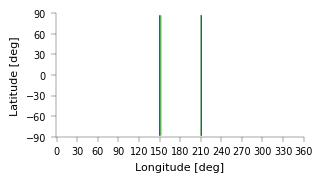

In [4]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
# isca_tools.plot.show_land(land_file_name)
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land

if save_fig or save_land_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [5]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'

temp_mean = np.zeros((n_kappa, n_pressure, n_lat))
r_mean = np.zeros((n_kappa, n_lat))          # compute mean rh as mean over rh on each day
z_mean = np.zeros((n_kappa, n_pressure, n_lat))

ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
        
        # if not aquaplanet, then is land and only consider land longitudes
        ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
        
        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        
        if mean_method == 'all':
            ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        elif mean_method != 'land':
            raise ValueError(f'Mean method is {mean_method} which is not valid.')
        temp_mean[j] = ds_use.temp.mean(dim='lon_time')
        z_mean[j] = ds_use.height.mean(dim='lon_time')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        r_mean[j] = rh_use.mean(dim='lon_time')
        pbar.update(1)
sphum_mean = r_mean * sphum_sat(temp_mean[:, ind_surf], p_surface)       # compute sphum_mean from r_mean

100%|██████████| 2/2 [00:21<00:00, 10.88s/it]


In [6]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
# relative humidity as function of temp quantile not temp quantile
r_quant3 = np.zeros((n_kappa, n_lat, n_quant))
z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
convflag_quant3 = np.zeros((n_kappa, n_lat, n_quant))
klzbs_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convfract_quant3 = np.zeros((n_kappa, n_lat, n_quant))            # record fraction of days convecting

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j]
        temp_quant3[j] = ds_use.temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose('pfull', 'lat', 'quantile')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        is_convecting = np.logical_and(ds_use.klzbs<klzb_thresh, ds_use.convflag > convflag_thresh)
        for k in range(n_lat):
            for q, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                r_quant3[j, k, q] = rh_use[k, use_ind].mean(dim='lon_time')
                convflag_quant3[j, k, q] = ds_use.convflag[k, use_ind].mean(dim='lon_time')
                klzbs_quant3[j, k, q] = ds_use.klzbs[k, use_ind].mean(dim='lon_time')
                convfract_quant3[j, k, q] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)
sphum_quant3 = sphum_sat(temp_quant3[:, ind_surf], p_surface) * r_quant3             # compute specific humidity from relative humidity
r_anom = r_quant3 - r_mean[:, :, np.newaxis]
temp_s_anom = temp_quant3[:, ind_surf] - temp_mean[:, ind_surf, :, np.newaxis]

100%|██████████| 2772/2772 [00:08<00:00, 342.31it/s]


In [7]:
temp_adiabat_anom = np.zeros((n_kappa, n_lat, n_quant))
temp_ce_mean = np.zeros((n_kappa, n_lat))
temp_ce_quant = np.zeros((n_kappa, n_lat, n_quant))
temp_ft_anom = np.zeros((n_kappa, n_lat, n_quant))
temp_adiabat_mean = np.zeros((n_kappa, n_lat))
for j in range(n_lat):
    temp_adiabat_anom[:, j], temp_ce_mean[:, j], temp_ce_quant[:, j], temp_ft_anom[:, j] = \
        decompose_temp_adiabat_anomaly(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[:, j], 
                                       sphum_quant3[:, j], temp_mean[:, ind_ft, j], temp_quant3[:, ind_ft, j], 
                                       p_surface, pressure_ft_actual)
    for i in range(n_kappa):
        temp_adiabat_mean[i, j] = get_temp_adiabat(temp_mean[i, ind_surf, j], sphum_mean[i, j], p_surface, pressure_ft_actual)
temp_ce_mean_change = temp_ce_mean[1] - temp_ce_mean[0]
temp_ce_quant_change = temp_ce_quant[1] - temp_ce_quant[0]
temp_ft_anom_change = temp_ft_anom[1] - temp_ft_anom[0]
z_ft_mod_anom = (z_quant3[:, ind_ft] - z_mean[:, ind_ft][:, :, np.newaxis]) * g / lnp_const 
temp_adiabat_anom_quant3_z_form = z_ft_mod_anom + np.expand_dims(temp_ce_mean, axis=-1) - temp_ce_quant

In [8]:
# Surface MSE
mse_quant3 = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, z_quant3[:, ind_surf])
mse_mean = moist_static_energy(temp_mean[:, ind_surf], sphum_mean, z_mean[:, ind_surf])
mse_mod_quant3 = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, height=0, 
                                        c_p_const=c_p - lnp_const)
mse_mod_mean = moist_static_energy(temp_mean[:, ind_surf], sphum_mean, height=0, c_p_const=c_p - lnp_const)

# Free troposphere MSE
mse_ft_sat_quant3 = moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), z_quant3[:, ind_ft])
mse_ft_sat_mean = moist_static_energy(temp_mean[:, ind_ft], sphum_sat(temp_mean[:, ind_ft], pressure_ft_actual), 
                                      z_mean[:, ind_ft])
mse_mod_ft_quant3 = moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), height=0, 
                                        c_p_const=c_p + lnp_const)
mse_mod_ft_mean = moist_static_energy(temp_mean[:, ind_ft], sphum_sat(temp_mean[:, ind_ft], pressure_ft_actual), height=0, c_p_const=c_p + lnp_const)

# CQE indicator
epsilon_quant3 = mse_quant3 - mse_ft_sat_quant3
epsilon_mean = mse_mean - mse_ft_sat_mean

## Test $z$ Relation
A crucial aspect to this theory is relating the geopotential height $z_{FT}$ to near-surface temperature $T$ and free troposphere temperature $T_{FT}$.

We start with two equations, from Zhang 2023. The first combines hydrostatic balance and the ideal gas law. The second assumes a constant lapse rate, $\Gamma$, for integration processes.

$d\ln p = -\frac{g}{RT(p)}dz$;      $z(p) - z_s = \frac{T_s - T(p)}{\Gamma}$

Combining the two, we get $d\ln p = \frac{g}{R\Gamma}d\ln T$.

Integrating between the free troposphere at 500hPa and surface at 1000hPa, we get:
$\ln(\frac{1000}{500}) = \ln 2 = \frac{g}{R\Gamma}\ln(\frac{T_s}{T_{500}})$ or $\frac{1}{\Gamma} = \frac{R\ln 2}{g\ln(\frac{T_s}{T_{500}})}$

We also have the $z$ equation applied at 500hPa: $z_{500} - z_s = \frac{T_s - T_{500}}{\Gamma}$. Combining the two, we get:
$z_{500} - z_s \approx \frac{R\ln 2(T_s - T_{500})}{g\ln(\frac{T_s}{T_{500}})}$

We can re-write the denominator in $\ln(1+x)$ form as $\ln(1+\frac{T_s-T_{500}}{T_{500}})$. Here $x=\frac{T_s-T_{500}}{T_{500}}$ and is small. Max value in tropics is about 0.15. 

The taylor series is $\frac{1}{\ln(1+x)} \approx \frac{1}{x} + \frac{1}{2} - \frac{x}{12} + ...$. Because $x$ is small, I propose keeping just the first two terms. In which case, we get:

$z_{500} - z_s \approx \frac{R\ln 2(T_s - T_{500})}{g}(\frac{T_{500}}{T_s-T_{500}} + \frac{1}{2}) = \frac{R\ln 2}{2g}(T_s + T_{500})$

The plots below shows that the taylor approximation is pretty accurate, but they are both bad approximations for the actual geopotential height.

In [9]:
def get_z_theory(temp_surf, temp_ft, taylor=True, pressure_surf=p_surface, pressure_ft=pressure_ft_actual):
    lnp_prefactor = R * np.log(pressure_surf/pressure_ft) / g
    if taylor:
        return lnp_prefactor/2 * (temp_surf + temp_ft)
    else:
        return lnp_prefactor * (temp_surf - temp_ft) / np.log(temp_surf/temp_ft)

z_theory_quant3 = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in ['full', 'taylor']}
z_theory_mean = {key: np.zeros((n_kappa, n_lat)) for key in ['full', 'taylor']}
for i in range(n_kappa):
    for key in z_theory_quant3:
        z_theory_quant3[key][i] = get_z_theory(temp_quant3[i, ind_surf], temp_quant3[i, ind_ft], True if key=='taylor' else False)
        z_theory_mean[key][i] = get_z_theory(temp_mean[i, ind_surf], temp_mean[i, ind_ft], True if key=='taylor' else False)

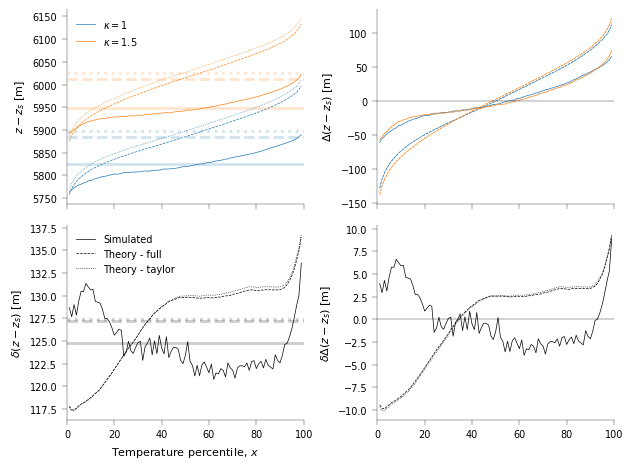

In [10]:
save_z_ft_fig = False
fig, ax = plt.subplots(2,2, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True)
linestyles_use = {'full': '--', 'taylor': ':'}
for i in range(n_kappa):
    ax[0, 0].plot(quant_plot, 
               np.average(z_quant3[i, ind_ft] - z_quant3[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i],
               label=f'$\\kappa={tau_lw[i]}$')
    ax[0, 0].axhline(np.average(z_mean[i, ind_ft]-z_mean[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i], lw=2, alpha=0.2)
    for key in z_theory_quant3:
        ax[0, 0].plot(quant_plot, 
                   np.average(z_theory_quant3[key][i], axis=0, weights=lat_weights), color=default_colors[i], 
                   linestyle=linestyles_use[key])
        ax[0, 0].axhline(np.average(z_theory_mean[key][i], axis=0, weights=lat_weights), color=default_colors[i], 
                      linestyle=linestyles_use[key], lw=2, alpha=0.2)
ax[1, 0].plot(quant_plot, 
           np.average(np.diff(z_quant3[:, ind_ft] - z_quant3[:, ind_surf], axis=0)[0], axis=0, weights=lat_weights), color='k',
           label='Simulated')
ax[1, 0].axhline(np.average(np.diff(z_mean[:, ind_ft]-z_mean[:, ind_surf], axis=0)[0], axis=0, weights=lat_weights), 
              color='k', lw=2, alpha=0.2)
for key in z_theory_quant3:
    ax[1, 0].plot(quant_plot, 
                   np.average(z_theory_quant3[key][1]-z_theory_quant3[key][0], axis=0, weights=lat_weights), 
               color='k', linestyle=linestyles_use[key], label=f'Theory - {key}')
    ax[1, 0].axhline(np.average(z_theory_mean[key][1]-z_theory_mean[key][0], axis=0, weights=lat_weights), color='k', 
                  linestyle=linestyles_use[key], lw=2, alpha=0.2)

for i in range(n_kappa):
    ax[0, 1].plot(quant_plot, 
               np.average(z_quant3[i, ind_ft] - z_quant3[i, ind_surf] - (z_mean[i, ind_ft]-z_mean[i, ind_surf])[:, np.newaxis], 
                          axis=0, weights=lat_weights), color=default_colors[i], label=f'$\\kappa={tau_lw[i]}$')
    for key in z_theory_quant3:
        ax[0, 1].plot(quant_plot, np.average(z_theory_quant3[key][i] - z_theory_mean[key][i][:, np.newaxis], axis=0, weights=lat_weights),
                      color=default_colors[i], linestyle=linestyles_use[key])
ax[1, 1].plot(quant_plot, 
           np.average(np.diff(z_quant3[:, ind_ft] - z_quant3[:, ind_surf] - (z_mean[:, ind_ft]-z_mean[:, ind_surf])[:, :, np.newaxis], axis=0)[0], 
                      axis=0, weights=lat_weights), color='k')
for key in z_theory_quant3:
    ax[1, 1].plot(quant_plot, 
                   np.average(z_theory_quant3[key][1]-z_theory_quant3[key][0] - (z_theory_mean[key][1]-z_theory_mean[key][0])[:, np.newaxis], 
                              axis=0, weights=lat_weights), color='k', linestyle=linestyles_use[key], label=f'Theory - {key}') 

ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 0].set_ylabel('$z-z_s$ [m]')
ax[0, 1].set_ylabel('$\Delta (z-z_s)$ [m]')
ax[1, 0].set_ylabel('$\delta (z-z_s)$ [m]')
ax[1, 1].set_ylabel('$\delta \Delta (z-z_s)$ [m]')
ax[1, 0].set_xlabel(percentile_label)
ax[0, 0].set_xlim(0, 100)
ax[0, 1].axhline(0, color='k', lw=ax_linewidth)
ax[1, 1].axhline(0, color='k', lw=ax_linewidth)
plt.tight_layout()
if save_fig or save_z_ft_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/land_z_ft_approx_{region}_{season}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## $\delta \Delta h_s^{\dagger}$ Approximation 1
To get a theoretical estimate of $\delta T_s(x)$, we need to do an expansion of $\delta \Delta h_s^{\dagger}$ in terms of $\Delta T_A$ and $\delta \Delta T_A$.

Below, we see how the accuracy of the $\delta \Delta h_s^{\dagger}$ approximation impacts on the $\delta T_s(x)$ prediction.

In [11]:
def scale_factor_theory_no_taylor_fit_func(scale_factor, temp_surf_mean, temp_surf_quant0, r_surf_mean, r_surf_quant, temp_ft_mean, temp_ft_quant, 
                                 z_surf_mean = None, z_surf_quant = None, z_ft_quant = None, z_ft_mean = None, epsilon_mean = None, 
                                 epsilon_quant = None, pressure_surf: float = p_surface, pressure_ft: float = pressure_ft_actual) -> float:
    # Finds scaling factor such that mse_s_quant - mse_s_mean = mse_ft_quant - mse_ft_mean + epsilon_quant - epsilon_mean
    # If z is not given, will assume z relation to temperature
    # If epsilon_mean not given, will assume CQE i.e. no change in epsilon anomaly with warming
    # Epsilon is in kJ/kg
    n_exp = len(r_surf_mean)
    temp_mean_change = temp_surf_mean[1] - temp_surf_mean[0]
    temp_quant_hot = temp_surf_quant0 + scale_factor * temp_mean_change
    
    if z_surf_mean is None:
        # Assume relation between z and temp
        z_surf_mean = np.zeros(n_exp)
        z_surf_quant = np.zeros(n_exp)
        z_ft_mean = np.zeros(n_exp)
        z_ft_quant = np.zeros(n_exp)
        c_p_const_surf = c_p - lnp_const
        c_p_const_ft = c_p + lnp_const
    else:
        c_p_const_surf = c_p
        c_p_const_ft = c_p
    
    mse_surf_quant_cold = moist_static_energy(temp_surf_quant0, r_surf_quant[0] * sphum_sat(temp_surf_quant0, pressure_surf), z_surf_quant[0],
                                              c_p_const=c_p_const_surf)
    mse_surf_quant_hot = moist_static_energy(temp_quant_hot, r_surf_quant[1] * sphum_sat(temp_quant_hot, pressure_surf), z_surf_quant[1], 
                                             c_p_const=c_p_const_surf)
    mse_surf_mean = [moist_static_energy(temp_surf_mean[i], r_surf_mean[i] * sphum_sat(temp_surf_mean[i], pressure_surf), z_surf_mean[i], 
                                         c_p_const=c_p_const_surf) 
                     for i in range(n_exp)]
    mse_ft_quant = [moist_static_energy(temp_ft_quant[i], sphum_sat(temp_ft_quant[i], pressure_ft), z_ft_quant[i], c_p_const=c_p_const_ft) 
                     for i in range(n_exp)]
    mse_ft_mean = [moist_static_energy(temp_ft_mean[i], sphum_sat(temp_ft_mean[i], pressure_ft), z_ft_mean[i], c_p_const=c_p_const_ft) 
                     for i in range(n_exp)]
    mse_surf_quant_change = mse_surf_quant_hot - mse_surf_quant_cold
    mse_surf_mean_change = mse_surf_mean[1] - mse_surf_mean[0]
    mse_ft_quant_change = mse_ft_quant[1] - mse_ft_quant[0]
    mse_ft_mean_change = mse_ft_mean[1] - mse_ft_mean[0]
    if epsilon_mean is not None:
        epsilon_quant_change = epsilon_quant[1] - epsilon_quant[0]
        epsilon_mean_change = epsilon_mean[1] - epsilon_mean[0]
    else:
        epsilon_quant_change = 0
        epsilon_mean_change = 0
    return mse_surf_quant_change - mse_surf_mean_change - (mse_ft_quant_change - mse_ft_mean_change) - (epsilon_quant_change - 
                                                                                                        epsilon_mean_change)

def scale_factor_theory_from_mse_anom_change_fit_func(scale_factor, temp_surf_mean, temp_surf_quant, r_surf_mean, r_surf_quant, 
                                                      mse_mod_anom_change, pressure_surf: float = p_surface):
    # mse_mod_anom_change is in kJ/kg
    n_exp = len(r_surf_mean)
    temp_mean_change = temp_surf_mean[1] - temp_surf_mean[0]
    temp_quant_hot = temp_surf_quant[0] + scale_factor * temp_mean_change
    mse_surf_quant_cold = moist_static_energy(temp_surf_quant[0], r_surf_quant[0] * sphum_sat(temp_surf_quant[0], pressure_surf), 0,
                                              c_p_const=c_p - lnp_const)
    mse_surf_quant_hot = moist_static_energy(temp_quant_hot, r_surf_quant[1] * sphum_sat(temp_quant_hot, pressure_surf), 0, 
                                             c_p_const=c_p - lnp_const)
    mse_surf_mean = [moist_static_energy(temp_surf_mean[i], r_surf_mean[i] * sphum_sat(temp_surf_mean[i], pressure_surf), 0, 
                                         c_p_const=c_p - lnp_const) 
                     for i in range(n_exp)]
    mse_mod_anom_change_from_sf = mse_surf_quant_hot - mse_surf_quant_cold - (mse_surf_mean[1] - mse_surf_mean[0])
    return mse_mod_anom_change_from_sf - mse_mod_anom_change

def scale_factor_theory_taylor_fit_func(scale_factor, temp_surf_mean, temp_surf_quant, r_surf_mean, r_surf_quant, 
                                        mse_mod_anom_change_from_temp_a, taylor_terms='linear', pressure_surf = p_surface, 
                                        pressure_ft=pressure_ft_actual, temp_use_rh_term=None):
    # Makes same taylor series approximation for both ways of getting mse_anom_change
    temp_mean_change = temp_surf_mean[1] - temp_surf_mean[0]
    temp_surf_quant_use = np.asarray([temp_surf_quant[0], temp_surf_quant[0] + scale_factor * temp_mean_change], dtype=np.float64)
    
    sphum_mean = r_surf_mean * sphum_sat(temp_surf_mean, pressure_surf)
    sphum_quant = r_surf_quant * sphum_sat(temp_surf_quant_use, pressure_surf)
    
    mse_quant_change_from_temp_s = do_delta_mse_mod_taylor_expansion(temp_surf_quant_use[:, np.newaxis], sphum_quant[:, np.newaxis], 
                                                                     pressure_surf, pressure_ft, taylor_terms=taylor_terms, 
                                                                     temp_use_rh_term=temp_use_rh_term)[0]
    mse_mean_change_from_temp_s = do_delta_mse_mod_taylor_expansion(temp_surf_mean, sphum_mean, 
                                                                     pressure_surf, pressure_ft, taylor_terms=taylor_terms)[0]
    mse_anom_change_from_temp_s = mse_quant_change_from_temp_s - mse_mean_change_from_temp_s
    return mse_mod_anom_change_from_temp_a - mse_anom_change_from_temp_s

In [12]:
mse_mod_anom_change_simulated = mse_mod_quant3[1] - mse_mod_mean[1, :, np.newaxis] - (mse_mod_quant3[0] - mse_mod_mean[0, :, np.newaxis])
mse_mod_anom_change_theory = {key: np.zeros((n_lat, n_quant)) for key in ['t_a_linear', 't_a_non_linear', 't_a_squared']}
for key in ['t_a_linear', 't_a_non_linear', 't_a_squared']:
    for i in range(n_lat):
        mse_mod_anom_change_theory[key][i] = get_delta_mse_mod_anom_theory(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i], 
                                                                           sphum_mean[:, i], sphum_quant3[:, i], p_surface, pressure_ft_actual,
                                                                           taylor_terms=key.replace('t_a_', ''))[0]

In [13]:
sf_denom = (temp_mean[1, ind_surf] - temp_mean[0, ind_surf])[:, np.newaxis]
sf_simulated = (temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf]) / sf_denom
sf_theory = {key: np.zeros((n_lat, n_quant)) for key in ['just_z', 't_a_linear', 't_a_non_linear', 't_a_squared']}
for i in range(n_lat):
    for j in range(n_quant):
        sf_theory['just_z'][i, j] = \
            scipy.optimize.fsolve(scale_factor_theory_no_taylor_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[0, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], temp_mean[:, ind_ft, i], temp_quant3[:, ind_ft, i, j], 
                                        None, None, None, None, epsilon_mean[:, i], epsilon_quant3[:, i, j]))
        for key in mse_mod_anom_change_theory:
            sf_theory[key][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                      args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                            r_quant3[:, i, j], mse_mod_anom_change_theory[key][i, j]))

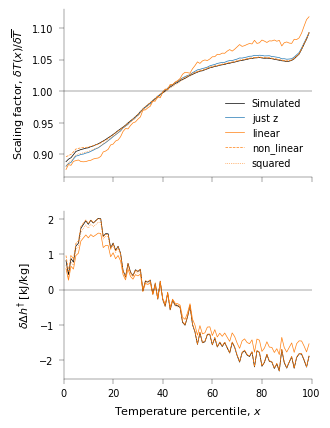

In [14]:
linestyles_sf_theory = {'linear': '-', 'non_linear': '--', 'squared': ':'}

save_delta_temp_theory_fig2 = False
fig_sf_theory, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax[0].plot(quant_plot, np.average(sf_simulated, weights=lat_weights, axis=0), color='k',
           label='Simulated')
ax[0].plot(quant_plot, np.average(sf_theory['just_z'], weights=lat_weights, axis=0), color=default_colors[0],
           label='just z')
for i, key in enumerate(mse_mod_anom_change_theory):
    if 't_a' not in key:
        continue
    ax[0].plot(quant_plot, np.average(sf_theory[key], weights=lat_weights, axis=0), color=default_colors[1], 
               linestyle=linestyles_sf_theory[key.replace('t_a_', '')], label=key.replace('t_a_', ''))
    
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_simulated, axis=0, weights=lat_weights), color='k', label='Simulated')
for i, key in enumerate(mse_mod_anom_change_theory):
    if 't_a' not in key:
        continue
    ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory[key], axis=0, weights=lat_weights), 
               label=key.replace('t_a', ''), linestyle=linestyles_sf_theory[key.replace('t_a_', '')], color=default_colors[1])
ax[0].legend()
ax[0].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax[1].set_ylabel('$\delta \Delta h^{\dagger}$ [kJ/kg]')
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

if save_fig or save_delta_temp_theory_fig2:
    fig_sf_theory.savefig(f"/Users/joshduffield/Desktop/land_sf_theory_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## $\delta \Delta h_s^{\dagger}$ Approximation 2
To get a theoretical estimate of $\delta T_s(x)$, we also need to do an expansion of $\delta h_s^{\dagger}(x)$ in terms of $\delta T_s(x)$, $\delta r_s(x)$ and similar for the mean.

Below, we see how the accuracy of this $\delta \Delta h_s^{\dagger}$ approximation impacts on the $\delta T_s(x)$ prediction.

In [15]:
mse_mod_quant_change_t_s_approx = {key: np.zeros((n_lat, n_quant)) for key in ['linear', 'non_linear', 'squared']}
mse_mod_mean_change_t_s_approx = {key: np.zeros(n_lat) for key in ['linear', 'non_linear', 'squared']}
for key in mse_mod_quant_change_t_s_approx:
    for i in range(n_lat):
        mse_mod_quant_change_t_s_approx[key][i] = do_delta_mse_mod_taylor_expansion(temp_quant3[:, ind_surf, i], sphum_quant3[:, i], 
                                                                                    p_surface, pressure_ft_actual, taylor_terms=key, temp_use_rh_term=temp_mean[0, ind_surf, i])[0]
        mse_mod_mean_change_t_s_approx[key][i] = do_delta_mse_mod_taylor_expansion(temp_mean[:, ind_surf, i], sphum_mean[:, i], 
                                                                                   p_surface, pressure_ft_actual, taylor_terms=key)[0]
for key in mse_mod_quant_change_t_s_approx:
    mse_mod_anom_change_theory['t_s_'+key] = mse_mod_quant_change_t_s_approx[key] - mse_mod_mean_change_t_s_approx[key][:, np.newaxis]

for key in mse_mod_quant_change_t_s_approx:
    sf_theory['t_s_'+key] = np.zeros((n_lat, n_quant))
    for i in range(n_lat):
        for j in range(n_quant):
            sf_theory['t_s_'+key][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                                                args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                                                      r_quant3[:, i, j], mse_mod_anom_change_theory['t_s_'+key][i, j]))

Text(0, 0.5, '$\\delta h^{\\dagger}$ [kJ/kg]')

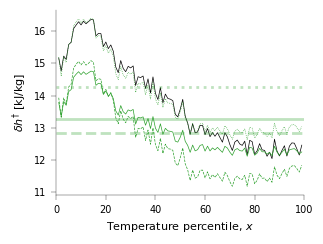

In [16]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(mse_mod_quant3[1]-mse_mod_quant3[0], axis=0, weights=lat_weights), color='k')
for key in mse_mod_quant_change_t_s_approx:
    ax.plot(quant_plot, np.average(mse_mod_quant_change_t_s_approx[key], axis=0, weights=lat_weights), color=default_colors[2], 
            linestyle=linestyles_sf_theory[key])
    ax.axhline(np.average(mse_mod_mean_change_t_s_approx[key], axis=0, weights=lat_weights), linestyle=linestyles_sf_theory[key], 
               color=default_colors[2], lw=2, alpha=0.3)
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.set_ylabel('$\delta h^{\dagger}$ [kJ/kg]')

In [17]:
for key in ['linear', 'non_linear', 'squared']:
    sf_theory[key] = np.zeros((n_lat, n_quant))
    for i in range(n_lat):
        mse_mod_anom_change_use = get_delta_mse_mod_anom_theory(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i], 
                                                                           sphum_mean[:, i], sphum_quant3[:, i], p_surface, pressure_ft_actual,
                                                                           taylor_terms=key,
                                                                mse_mod_mean_change=mse_mod_mean_change_t_s_approx['linear'][i]*1000)[0]
        # print(key + ' ' +str(np.max(np.abs(mse_mod_anom_change_use - mse_mod_anom_change_theory['t_a_'+key][i]))))
        for j in range(n_quant):
            sf_theory[key][i, j] = scipy.optimize.fsolve(scale_factor_theory_taylor_fit_func, 1, 
                                                         args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                                               r_quant3[:, i, j], mse_mod_anom_change_use[j], key))

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_58813/3932726364.py:69: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  temp_surf_quant_use = np.asarray([temp_surf_quant[0], temp_surf_quant[0] + scale_factor * temp_mean_change], dtype=np.float64)
/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


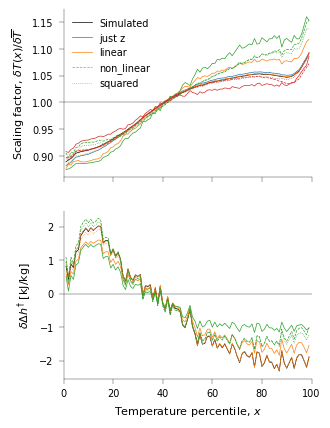

In [18]:
save_delta_temp_theory_fig3 = False
fig = copy.deepcopy(fig_sf_theory)
ax = fig.axes
for i, key in enumerate(mse_mod_anom_change_theory):
    if 't_s' not in key:
        continue
    ax[0].plot(quant_plot, np.average(sf_theory[key], weights=lat_weights, axis=0), color=default_colors[2], 
               linestyle=linestyles_sf_theory[key.replace('t_s_', '')])
    ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory[key], axis=0, weights=lat_weights), 
               linestyle=linestyles_sf_theory[key.replace('t_s_', '')], color=default_colors[2])
ax[0].plot(quant_plot, np.average(sf_theory['linear'], axis=0, weights=lat_weights), color=default_colors[3])
ax[0].plot(quant_plot, np.average(sf_theory['non_linear'], axis=0, weights=lat_weights), color=default_colors[3], linestyle='--')
ax[0].plot(quant_plot, np.average(sf_theory['squared'], axis=0, weights=lat_weights), color=default_colors[3], linestyle=':')
if save_fig or save_delta_temp_theory_fig3:
    fig.savefig(f"/Users/joshduffield/Desktop/land_sf_theory2_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
fig

### RH Change MSE contribution
In the theory for $\delta T_s(x)$, there is a $L_v q_s^*\delta \overline{r_s} - L_v q_s^*(x) \delta r_s(x)$ term. Below we check if we can approximate this.

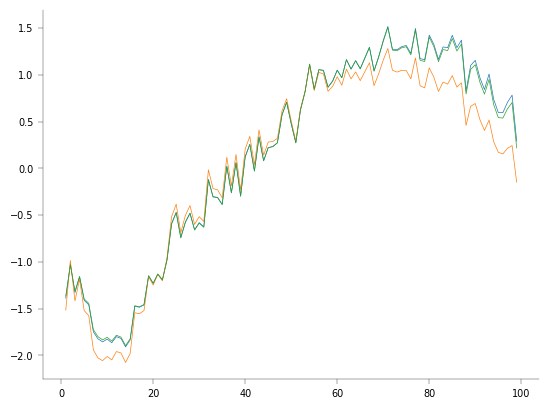

In [19]:
q_sat_s = sphum_sat(temp_mean[0, ind_surf], p_surface)
alpha_s = clausius_clapeyron_factor(temp_mean[0, ind_surf], p_surface)
r_change_mse_cont = ((L_v * q_sat_s * (r_mean[1] - r_mean[0]))[:, np.newaxis] - 
                    L_v * sphum_sat(temp_quant3[0, ind_surf], p_surface)  * (r_quant3[1] - r_quant3[0]))/1000
r_change_mse_cont_term1 = L_v * q_sat_s[:, np.newaxis] * ((r_mean[1] - r_mean[0])[:, np.newaxis] - (r_quant3[1] - r_quant3[0]))/1000
r_change_mse_cont_term2 = -L_v * (q_sat_s * alpha_s)[:, np.newaxis] * \
                          (r_mean[1]-r_mean[0])[:, np.newaxis] * (temp_quant3[0, ind_surf] - temp_mean[0, ind_surf, :, np.newaxis])/1000
r_change_mse_cont_term3 = -L_v * (q_sat_s * alpha_s)[:, np.newaxis] * (
        r_quant3[1] - r_quant3[0] - (r_mean[1]-r_mean[0])[:, np.newaxis]) * (temp_quant3[0, ind_surf] - temp_mean[0, ind_surf, :, np.newaxis])/1000
plt.plot(quant_plot, np.average(r_change_mse_cont, axis=0, weights=lat_weights))
plt.plot(quant_plot, np.average(r_change_mse_cont_term1, 
                                axis=0, weights=lat_weights))
plt.plot(quant_plot, np.average(r_change_mse_cont_term1+r_change_mse_cont_term2+r_change_mse_cont_term3, axis=0, weights=lat_weights))

NameError: name 'delta_temp_theory' is not defined

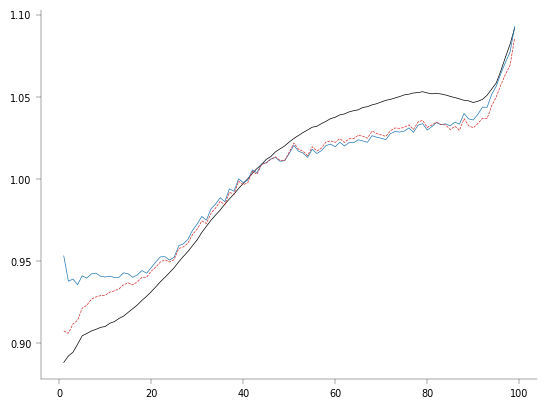

In [20]:
gamma = {key: np.zeros(n_lat) for key in ['temp_s', 'humidity', 'r_change', 'temp_a_change', 
                                          'temp_s_r_mean_change','humidity_r_mean_change', 'temp_s_r_change', 
                                          'temp_s_squared', 'humidity_squared', 'temp_s_humidity']}
for i in range(n_lat):
    gamma['temp_s'][i], gamma['humidity'][i], gamma['r_change'][i], gamma['temp_a_change'][i], gamma['temp_s_r_mean_change'][i], \
            gamma['humidity_r_mean_change'][i], gamma['temp_s_r_change'][i], gamma['temp_s_squared'][i], gamma['humidity_squared'][i], \
        gamma['temp_s_humidity'][i] = get_gamma_factors3(temp_mean[0, ind_surf, i], sphum_mean[0, i], p_surface, pressure_ft_actual)
sf_theory_cont = {}
sf_theory_cont['temp_s'] = gamma['temp_s'][:, np.newaxis] * temp_s_anom[0] / temp_mean[0, ind_surf, :, np.newaxis]
sf_theory_cont['humidity'] = gamma['humidity'][:, np.newaxis] * (r_quant3[0] - r_mean[0, :, np.newaxis])/r_mean[0, :, np.newaxis]
sf_theory_cont['r_change'] = gamma['r_change'][:, np.newaxis] * (r_anom[1]-r_anom[0])/r_mean[0][:, np.newaxis]/sf_denom
sf_theory_cont['temp_a_change'] = gamma['temp_a_change'][:, np.newaxis] * (temp_adiabat_anom[1]-temp_adiabat_anom[0])/sf_denom
sf_theory_cont['temp_s_r_mean_change'] = gamma['temp_s_r_mean_change'][:, np.newaxis] * temp_s_anom[0] / temp_mean[0, ind_surf, :, np.newaxis] * \
                                         (r_mean[1] - r_mean[0])[:, np.newaxis]/r_mean[0, :, np.newaxis]/sf_denom
sf_theory_cont['humidity_r_mean_change'] = gamma['humidity_r_mean_change'][:, np.newaxis] * \
                                           r_anom[0]*(r_mean[1] - r_mean[0])[:, np.newaxis]/r_mean[0, :, np.newaxis]**2/sf_denom
sf_theory_cont['temp_s_r_change'] = gamma['temp_s_r_change'][:, np.newaxis] * temp_s_anom[0] / temp_mean[0, ind_surf, :, np.newaxis] * \
    (r_anom[1]-r_anom[0])/r_mean[0][:, np.newaxis]/sf_denom
sf_theory_cont['temp_s_squared'] = gamma['temp_s_squared'][:, np.newaxis] * (temp_s_anom[0] / temp_mean[0, ind_surf, :, np.newaxis])**2
# sf_theory_cont['humidity_squared'] = gamma['humidity_squared'][:, np.newaxis] * ((r_quant3[0] - r_mean[0, :, np.newaxis])/r_mean[0, :, np.newaxis])**2
# sf_theory_cont['temp_s_humidity'] = gamma['temp_s_humidity'][:, np.newaxis] * (temp_s_anom[0] / temp_mean[0, ind_surf, :, np.newaxis]) * \
#     ((r_quant3[0] - r_mean[0, :, np.newaxis])/r_mean[0, :, np.newaxis])
# print(np.abs(sf_theory_cont['temp_s_humidity']).max())

plt.plot(quant_plot, np.average(sf_simulated, weights=lat_weights, axis=0), color='k', label='Simulated')
plt.plot(quant_plot, np.average(1+sum([sf_theory_cont[key] for key in sf_theory_cont]), axis=0, weights=lat_weights))
plt.plot(quant_plot, np.average(sf_theory['linear'], axis=0, weights=lat_weights), color=default_colors[3], linestyle='--')
plt.plot(quant_plot, np.average(delta_temp_theory['wtg']/sf_denom, axis=0, weights=lat_weights), color='k', linestyle=':', label='Theory')
# sf_theory_cont['r_mean_change'] = (gamma['r_mean_change'] * (r_mean[1]-r_mean[0])/r_mean[0])[:, np.newaxis]
# sf_theory_cont['temp_s_r_mean_change'] = gamma['r_mean_change'][:, np.newaxis] * temp_s_anom[0] * \
#                                          ((r_mean[1]-r_mean[0])/r_mean[0])[:, np.newaxis]/sf_denom
# sf_theory_cont['temp_s_r_anom_change'] = gamma['temp_s_r_anom_change'][:, np.newaxis] * temp_s_anom[0] * \
#                                          (r_anom[1]-r_anom[0])/r_mean[0][:, np.newaxis]/sf_denom
# sf_theory_cont['temp_a_change_temp_mean_change'] = gamma['temp_a_change_temp_mean_change'][:, np.newaxis] * (
#         temp_adiabat_anom[1]-temp_adiabat_anom[0])
# sf_theory_cont['temp_a_change_temp_mean_change'] = 0

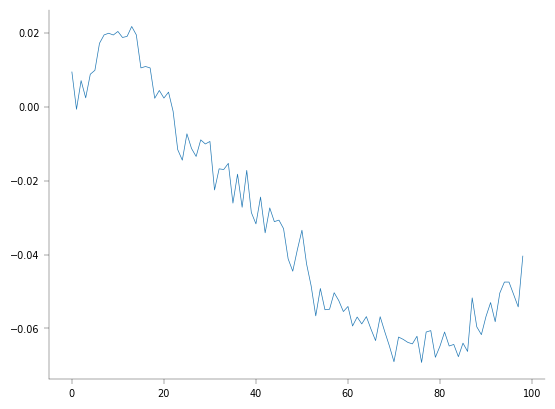

In [21]:
mu = L_v * clausius_clapeyron_factor(temp_quant3[0, ind_surf], p_surface) * sphum_quant3[0]
mu = mu / (c_p - lnp_const + mu)
mu_factor = mu * (r_quant3[1]-r_quant3[0])/r_quant3[0]
plt.plot(np.average(mu_factor, axis=0, weights=lat_weights))

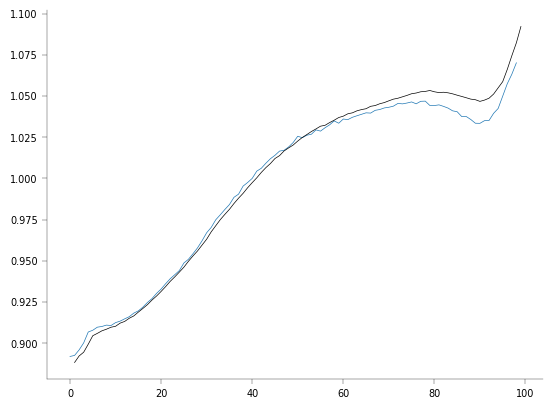

In [22]:
_, _, _, beta_s1, beta_s2, beta_s3 = get_theory_prefactor_terms(temp_mean[0, ind_surf], p_surface, pressure_ft_actual, sphum_mean[0])
_, _, _, beta_s1_x, _, _ = get_theory_prefactor_terms(temp_quant3[0, ind_surf], p_surface, pressure_ft_actual, sphum_quant3[0])
_, _, _, beta_a1, beta_a2, _ = get_theory_prefactor_terms(temp_adiabat_mean[0], p_surface, pressure_ft_actual)

term1 = -L_v * sphum_quant3[0] * (r_quant3[1]-r_quant3[0])/r_quant3[0]/sf_denom/beta_s1_x
term2 = mse_mod_mean_change_t_s_approx['non_linear'][:, np.newaxis]*1000/sf_denom/beta_s1_x
term3 = mse_mod_anom_change_theory['t_a_non_linear']*1000/sf_denom/beta_s1_x

plt.plot(np.average((term1+term2+term3)/(1+mu_factor), axis=0, weights=lat_weights))
plt.plot(quant_plot, np.average(sf_simulated, weights=lat_weights, axis=0), color='k', label='Simulated')

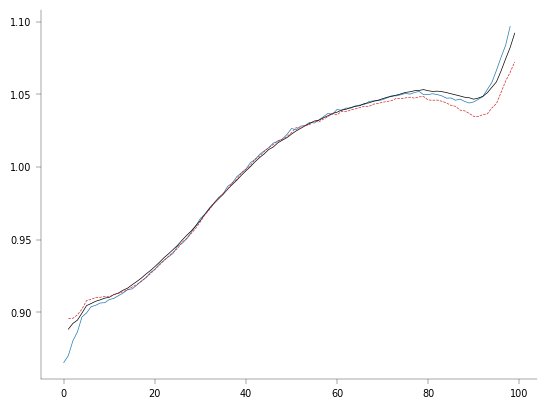

In [73]:
mse_mod_anom = mse_mod_quant3 - mse_mod_mean[:, :, np.newaxis]
mse_mod_mean_change_use = beta_s1 * (temp_mean[1, ind_surf] - temp_mean[0, ind_surf])/1000
beta_s1_x_inverse_approx = 1/beta_s1[:, np.newaxis] * (1 - (beta_s1_x-beta_s1[:, np.newaxis])/beta_s1[:, np.newaxis] + ((beta_s1_x-beta_s1[:, np.newaxis])/beta_s1[:, np.newaxis])**2)
temp_s_anom0_norm = temp_s_anom[0] / temp_mean[0, ind_surf, :, np.newaxis]
r_anom0_norm = r_anom[0]/r_mean[0, :, np.newaxis]
# mse_mod_anom0_use = mse_mod_anom[0]
mse_mod_anom0_use = (beta_s1[:, np.newaxis] * temp_s_anom[0] + L_v * sphum_mean[0, :, np.newaxis] * r_anom0_norm + 
                     0.5 * beta_s2[:, np.newaxis] * temp_s_anom[0] * temp_s_anom0_norm + 
                     L_v * (sphum_mean[0] * alpha_s)[:, np.newaxis] * r_anom0_norm * temp_s_anom[0])/1000
beta_s1_anom_approx = beta_s2[:, np.newaxis] * temp_s_anom0_norm + L_v * alpha_s[:, np.newaxis] * sphum_mean[0, :, np.newaxis] * r_anom0_norm + \
                      0.5 * beta_s3[:, np.newaxis] * temp_s_anom0_norm**2 + beta_s2[:, np.newaxis] * temp_s_anom0_norm * r_anom0_norm + 0.5 * beta_s3[:, np.newaxis] * temp_s_anom0_norm**2 * r_anom0_norm
beta_s1_anom_squared_approx = (beta_s2[:, np.newaxis] * temp_s_anom0_norm)**2 + \
                              (L_v * alpha_s[:, np.newaxis] * sphum_mean[0, :, np.newaxis] * r_anom0_norm)**2 + \
                              2 * (beta_s2 * L_v * alpha_s * sphum_mean[0])[:, np.newaxis] * temp_s_anom0_norm * r_anom0_norm + \
                              (2 * beta_s2**2)[:, np.newaxis] * temp_s_anom0_norm**2 * r_anom0_norm + \
                              (2 * L_v * alpha_s * sphum_mean[0] * beta_s2)[:, np.newaxis] * temp_s_anom0_norm * r_anom0_norm**2
beta_s1_x_inverse_approx2 = 1/beta_s1[:, np.newaxis] * (1 - beta_s1_anom_approx/beta_s1[:, np.newaxis] + beta_s1_anom_squared_approx/beta_s1[:, np.newaxis]**2)
term1 = beta_a1[:, np.newaxis] * (temp_adiabat_anom[1]-temp_adiabat_anom[0])/sf_denom/beta_s1[:, np.newaxis]
term2 = -L_v * sphum_quant3[0] * (r_quant3[1]-r_quant3[0])/r_quant3[0]/sf_denom/beta_s1[:, np.newaxis]
term2_a = (-L_v * q_sat_s/beta_s1 * (r_mean[1]-r_mean[0]))[:, np.newaxis]/sf_denom
term2_b = (-L_v * q_sat_s/beta_s1)[:, np.newaxis] * (r_anom[1]-r_anom[0])/sf_denom
term2_c = (-L_v * q_sat_s * alpha_s/beta_s1)[:, np.newaxis] * temp_s_anom[0] * (r_mean[1]-r_mean[0])[:, np.newaxis]/sf_denom
term2_d = (-L_v * q_sat_s * alpha_s/beta_s1)[:, np.newaxis] * temp_s_anom[0] * (r_anom[1]-r_anom[0])/sf_denom
term3 = (beta_a2/beta_a1**2/temp_adiabat_mean[0])[:, np.newaxis] * mse_mod_anom0_use * mse_mod_mean_change_use[:, np.newaxis]*1000**2/sf_denom/beta_s1[:, np.newaxis]
term4 = (beta_a2/beta_a1/temp_adiabat_mean[0])[:, np.newaxis] * (temp_adiabat_anom[1]-temp_adiabat_anom[0]) * mse_mod_mean_change_use[:, np.newaxis]*1000/sf_denom/beta_s1[:, np.newaxis]
term5 = mse_mod_mean_change_t_s_approx['non_linear'][:, np.newaxis]*1000/sf_denom*beta_s1_x_inverse_approx2
term5_a = (beta_s1 * (temp_mean[1, ind_surf] - temp_mean[0, ind_surf]))[:, np.newaxis]/sf_denom*beta_s1_x_inverse_approx2
term5_b = (L_v * sphum_mean[0] * (r_mean[1]-r_mean[0])/r_mean[0])[:, np.newaxis]/sf_denom/beta_s1[:, np.newaxis]
term5_c = (L_v * alpha_s * sphum_mean[0] * (temp_mean[1, ind_surf] - temp_mean[0, ind_surf]) * 
           (r_mean[1]-r_mean[0])/r_mean[0])[:, np.newaxis]/sf_denom/beta_s1[:, np.newaxis]
plt.plot(np.average((term1+term2_a+term2_b+term2_c+term2_d+term3+term4+term5_a+term5_b+term5_c)/(1+mu_factor), axis=0, weights=lat_weights))
plt.plot(quant_plot, np.average(sf_simulated, weights=lat_weights, axis=0), color='k', label='Simulated')
plt.plot(quant_plot, np.average(sf_theory['non_linear'], axis=0, weights=lat_weights), color=default_colors[3], linestyle='--')

In [65]:
term2

array([[ 0.03781326,  0.07347285,  0.07337062, ...,  0.16530355,
         0.19150423,  0.19443839],
       [ 0.07791543,  0.071249  ,  0.04956038, ...,  0.20942368,
         0.18660676,  0.11628894],
       [ 0.01842599,  0.02410523, -0.02873148, ...,  0.10885454,
         0.05222229,  0.06759726],
       ...,
       [-0.02702679, -0.04629417, -0.04288154, ...,  0.17865909,
         0.11614469,  0.07319239],
       [ 0.0505345 ,  0.06687323,  0.038377  , ...,  0.13864839,
         0.15280685,  0.09571423],
       [ 0.11679551,  0.11565936,  0.0754494 , ...,  0.22719861,
         0.23586188,  0.26705197]])

In [67]:
term2_a+term2_b+term2_c+term2_d - term2

array([[-0.00422562, -0.00611673, -0.00494385, ..., -0.00930378,
        -0.01189269, -0.01363396],
       [-0.00703628, -0.00491169, -0.00256754, ..., -0.00899452,
        -0.00892952, -0.00636727],
       [-0.00137247, -0.00137617,  0.0013534 , ..., -0.00367333,
        -0.00197992, -0.00301554],
       ...,
       [ 0.00190535,  0.00251334,  0.00194404, ..., -0.00613828,
        -0.0046454 , -0.00345529],
       [-0.00446304, -0.00427847, -0.00188489, ..., -0.00586249,
        -0.00726509, -0.00541915],
       [-0.01239446, -0.00930839, -0.00473479, ..., -0.01178219,
        -0.01370231, -0.01799166]])

In [42]:
term5_a+term5_b+term5_c-term5

array([[ 0.00000000e+00,  1.11022302e-16,  0.00000000e+00, ...,
         0.00000000e+00,  1.11022302e-16,  1.11022302e-16],
       [ 0.00000000e+00,  0.00000000e+00,  1.11022302e-16, ...,
         0.00000000e+00,  1.11022302e-16,  1.11022302e-16],
       [-1.11022302e-16,  0.00000000e+00,  0.00000000e+00, ...,
         1.11022302e-16,  2.22044605e-16,  0.00000000e+00],
       ...,
       [-4.44089210e-16, -3.33066907e-16, -5.55111512e-16, ...,
        -3.33066907e-16, -4.44089210e-16, -5.55111512e-16],
       [ 1.11022302e-16,  1.11022302e-16,  1.11022302e-16, ...,
         0.00000000e+00,  2.22044605e-16,  0.00000000e+00],
       [ 1.11022302e-16,  1.11022302e-16,  1.11022302e-16, ...,
         2.22044605e-16,  1.11022302e-16,  2.22044605e-16]])

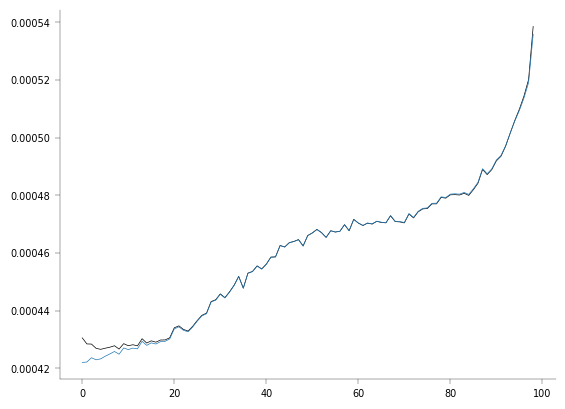

In [38]:
plt.plot(np.average(1/beta_s1_x, axis=0, weights=lat_weights), color='k')
plt.plot(np.average(beta_s1_x_inverse_approx2, axis=0, weights=lat_weights))

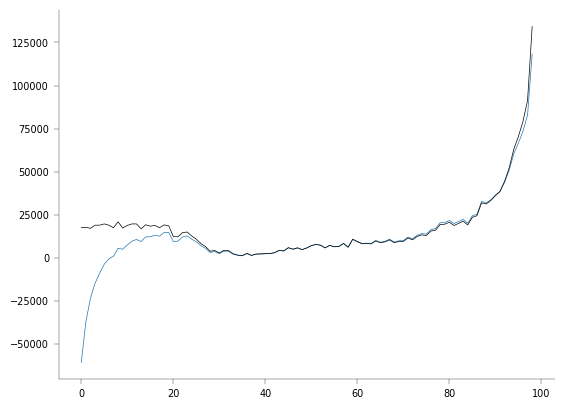

In [39]:
# plt.plot(np.average(beta_s1_anom_approx, axis=0, weights=lat_weights))
# plt.plot(np.average(beta_s1_x-beta_s1[:, np.newaxis], axis=0, weights=lat_weights), color='k')

plt.plot(np.average(beta_s1_anom_squared_approx, axis=0, weights=lat_weights))
plt.plot(np.average((beta_s1_x-beta_s1[:, np.newaxis])**2, axis=0, weights=lat_weights), color='k')

In [ ]:
term3

## Check out current linear theory
Below I plot the breakdown of the current linear theory applied to land.

In [ ]:
delta_temp_theory = {'wtg': np.zeros((n_lat, n_quant))}
delta_temp_theory_prefactors = {'wtg': {key: np.zeros((n_lat, n_quant)) for key in ['temp_s', 'humidity', 'r_change', 'temp_a_change']}}
delta_temp_theory_changes = copy.deepcopy(delta_temp_theory_prefactors)
delta_temp_theory_cont = copy.deepcopy(delta_temp_theory_prefactors)
for j in range(n_lat):
    delta_temp_theory['wtg'][j], info_coef, info_change = \
        get_delta_temp_quant_theory_simple2(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[:, j], 
                                            sphum_quant3[:, j], p_surface, pressure_ft_actual, include_squared_terms=True)
    for var in delta_temp_theory_prefactors['wtg']:
        delta_temp_theory_prefactors['wtg'][var][j] = info_coef[var]
        delta_temp_theory_changes['wtg'][var][j] = info_change[var]
        delta_temp_theory_cont['wtg'][var][j] = info_coef[var] * info_change[var]

In [ ]:
delta_temp_theory_cont['wtg']['temp_ce_change'] = delta_temp_theory_prefactors['wtg']['temp_a_change'] * \
                                                    (temp_ce_mean_change[:, np.newaxis] - temp_ce_quant_change)
delta_temp_theory_cont['wtg']['temp_ft_change'] = delta_temp_theory_prefactors['wtg']['temp_a_change'] * temp_ft_anom_change

In [ ]:
_, _, _, beta_s1, _, _ = get_theory_prefactor_terms(temp_mean[0, ind_surf], p_surface, pressure_ft_actual, sphum_mean[0])
_, _, _, beta_a1, beta_a2, _ = get_theory_prefactor_terms(temp_adiabat_mean[0], p_surface, pressure_ft_actual)

delta_temp_theory_cont['wtg_epsilon'] = copy.deepcopy(delta_temp_theory_cont['wtg'])
del delta_temp_theory_cont['wtg_epsilon']['temp_ce_change']
delta_temp_theory_cont['wtg_epsilon']['epsilon_change'] = 1000*np.diff((epsilon_quant3-
                                                                              epsilon_mean[:, :, np.newaxis]), axis=0
                                                                             )[0] / beta_s1[:, np.newaxis]
delta_temp_theory_cont['wtg_epsilon']['epsilon'] = -(beta_a2 / (beta_a1**2 * temp_adiabat_mean[0])
                                                           )[:, np.newaxis] * 1000 *(epsilon_quant3[0] - 
                                                                                     epsilon_mean[0, :, np.newaxis]
                                                                                     ) * np.diff(temp_mean[:, ind_surf], axis=0)[0, :, np.newaxis]
delta_temp_theory['wtg_epsilon'] = delta_temp_theory['wtg']-\
                                     delta_temp_theory_cont['wtg']['temp_ce_change']+\
                                     delta_temp_theory_cont['wtg_epsilon']['epsilon_change']+\
                                     delta_temp_theory_cont['wtg_epsilon']['epsilon']

In [ ]:
# exp_new_plot = 'wtg'
exp_new_plot = 'wtg_epsilon'

colors_breakdown = {'temp_s': default_colors[3], 'humidity': default_colors[0],  
                    'r_change': default_colors[0], 'temp_a_change': default_colors[2], 
                    'temp_ce_change': default_colors[1], 'temp_ft_change': default_colors[2]}
linestyles_breakdown = {key: '-' for key in colors_breakdown}
linestyles_breakdown['humidity'] = '--'
linestyles_breakdown['temp_s'] = '--'
colors_breakdown['epsilon'] = colors_breakdown['temp_ce_change']
colors_breakdown['epsilon_change'] = colors_breakdown['temp_ce_change']
linestyles_breakdown['epsilon'] = '--'
linestyles_breakdown['epsilon_change'] = '-'

save_sf_theory_breakdown_new_fig2 = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
ax = [ax]
ax[0].plot(quant_plot, np.average((temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf])/sf_denom, weights=lat_weights, axis=0), 
           color='k', label='Simulated')
ax[0].plot(quant_plot, np.average(delta_temp_theory[exp_new_plot]/sf_denom, axis=0, weights=lat_weights), color='k', linestyle=':', label='Theory')
for key in delta_temp_theory_cont[exp_new_plot]:
    if 'temp_a' in key:
        continue
    if 'epsilon' in key:
        continue
    # if key not in ['temp_s', 'humidity', 'r_change', 'temp_ft_change']:
    #     continue
    ax[0].plot(quant_plot, np.average(delta_temp_theory_cont[exp_new_plot][key]/sf_denom, weights=lat_weights, axis=0)+1,
               color=colors_breakdown[key], linestyle=linestyles_breakdown[key])
for i in range(len(ax)):
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
    ax[i].legend()
ax[0].set_xlim(0,100)
ax[-1].set_xlabel(percentile_label)
ax[0].set_ylim(0.7, 1.23)

if save_fig or save_sf_theory_breakdown_new_fig2:
    file_name = f"sf_breakdown_{exp_new_plot}_{region.lower()}_{season}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)